# Autocorrelation and Partial Autocorrelation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('Resources/daily-minimum-temperatures-in-me.csv')
df = df.rename(columns= {'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'Temp_min'})
# df = df.replace('?0.8', '0.8')

In [2]:
# df[df['Temp_min'].str.startswith('?')]
df['Temp_min'] = df['Temp_min'].str.replace('?', '')
df.head()

,Date,Temp_min
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [3]:
df["Temp_min"].max()

'9.9'

In [4]:
df['Temp_min'] = df['Temp_min'].astype('float')
df.describe()

,Temp_min
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


Text(0, 0.5, 'Min Temp')

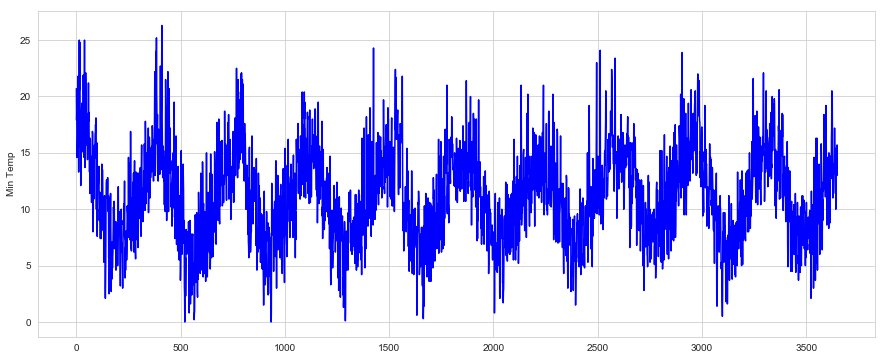

In [5]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,6))
ax = fig.gca()
df['Temp_min'].plot(c='blue')
ax.set_ylabel("Min Temp")

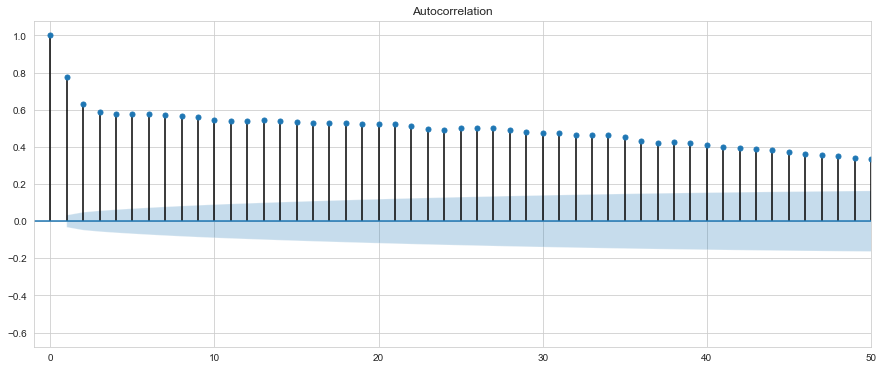

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
# x = df['Temp_min'].values.reshape[-1,1]
fig = plt.figure(figsize=(15,6))
fig.clf()
ax = fig.gca()
plot_acf(df['Temp_min'], alpha=0.05, ax=ax)
ax.set_xlim(-1,50)
plt.show()

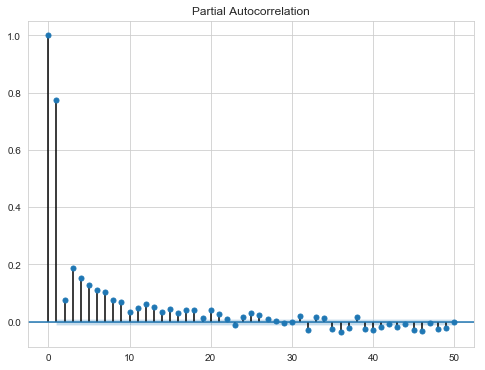

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
fig = plt.figure(figsize=(8,6))
fig.clf()
ax = fig.gca()
plot_pacf(df['Temp_min'], alpha = 0.5, lags=50, ax = ax)
plt.show()

# Calling R STL Package in Python

In [10]:
import pandas as pd

from rpy2.robjects import r, pandas2ri
import numpy as np
from rpy2.robjects.packages import importr


def decompose(series, frequency, s_window = 'periodic', log = False,  **kwargs):
    '''
    Decompose a time series into seasonal, trend and irregular components using loess, 
    acronym STL.
    https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/stl

    params:
        series: a time series

        frequency: the number of observations per “cycle” 
                   (normally a year, but sometimes a week, a day or an hour)
                   https://robjhyndman.com/hyndsight/seasonal-periods/

        s_window: either the character string "periodic" or the span 
                 (in lags) of the loess window for seasonal extraction, 
                 which should be odd and at least 7, according to Cleveland 
                 et al.

        log:    boolean.  take log of series



        **kwargs:  See other params for stl at 
           https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/stl
    '''

    df = pd.DataFrame()
    df['date'] = series.index
    if log: series = series.pipe(np.log)
    s = [x for x in series.values]
    length = len(series)
    s = r.ts(s, frequency=frequency)
    decomposed = [x for x in r.stl(s, s_window).rx2('time.series')]
    df['observed'] = series.values
    df['trend'] = decomposed[length:2*length]
    df['seasonal'] = decomposed[0:length]
    df['residuals'] = decomposed[2*length:3*length]
    return df

# Resampling time series data with pandas
We’re going to be tracking a self-driving car at 15 minute periods over a year and creating weekly and yearly summaries.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We’ll be tracking this self-driving car that travels at an average speed between 0 and 60 mph, all day long, all year long.

We have the average speed over the fifteen minute period in miles per hour, distance in miles and the cumulative distance travelled.

Our time series is set to be the index of a pandas DataFrame.

In [12]:
range = pd.date_range('2015-01-01', '2015-12-31', freq='15min')
df = pd.DataFrame(index = range)

# Average speed in miles per hour
df['speed'] = np.random.randint(low=0, high=60, size=len(df.index))
# Distance in miles (speed * 15/60 hours) data for every 15 minutes available
df['distance'] = df['speed'] * 0.25 
# Cumulative distance travelled
df['cumulative_distance'] = df.distance.cumsum()
df.head()

,speed,distance,cumulative_distance
2015-01-01 00:00:00,27,6.75,6.75
2015-01-01 00:15:00,49,12.25,19.00
2015-01-01 00:30:00,12,3.00,22.00
2015-01-01 00:45:00,43,10.75,32.75
2015-01-01 01:00:00,35,8.75,41.50


The resample method in pandas is similar to its groupby method as you are essentially grouping by a certain time span. You then specify a method of how you would like to resample.

So we’ll start with resampling the speed of our car:

* df.speed.resample() will be used to resample the speed column of our DataFrame
* The 'W' indicates we want to resample by week. At the bottom of this post is a summary of different time frames.
* mean() is used to indicate we want the mean speed during this period.
* With distance, we want the sum of the distances over the week to see how far the car travelled over the week, in that case we use sum().
* With cumulative distance we just want to take the last value as it’s a running cumulative total, so in that case we use last().

#### Resampling options
pandas comes with many in-built options for resampling, and you can even define your own methods.

In terms of date ranges, the following is a table for common time period options when resampling a time series:

Alias	Description
B	Business day
D	Calendar day
W	Weekly
M	Month end
Q	Quarter end
A	Year end
BA	Business year end
AS	Year start
H	Hourly frequency
T, min	Minutely frequency
S	Secondly frequency
L, ms	Millisecond frequency
U, us	Microsecond frequency
N, ns	Nanosecond frequency

These are some of the common methods you might use for resampling:
Method	Description
bfill	Backward fill
count	Count of values
ffill	Forward fill
first	First valid data value
last	Last valid data value
max	Maximum data value
mean	Mean of values in time range
median	Median of values in time range
min	Minimum data value
nunique	Number of unique values
ohlc	Opening value, highest value, lowest value, closing value
pad	Same as forward fill
std	Standard deviation of values
sum	Sum of values
var	Variance of values

In [13]:
weekly_summary = pd.DataFrame()
weekly_summary['speed'] = df.speed.resample('W').mean()
weekly_summary['distance'] = df.distance.resample('W').sum()
weekly_summary['cumulative_distance'] = df.cumulative_distance.resample('W').last()

#Select only whole weeks
weekly_summary = weekly_summary.truncate(before='2015-01-05', after='2015-12-27')
weekly_summary.head()

,speed,distance,cumulative_distance
2015-01-11,29.760417,4999.75,7868.50
2015-01-18,29.133929,4894.50,12763.00
2015-01-25,29.980655,5036.75,17799.75
2015-02-01,29.383929,4936.50,22736.25
2015-02-08,30.133929,5062.50,27798.75


* Resample annually

In [14]:
annual_summary = pd.DataFrame()
# AS is year-start frequency
annual_summary['speed'] = df.speed.resample('AS').mean()
annual_summary['distance'] = df.speed.resample('AS').sum()
annual_summary['cumulative_distance'] = df.cumulative_distance.resample('AS').last()
annual_summary

,speed,distance,cumulative_distance
2015-01-01,29.486851,1030418,257604.5


### Upsampling Data
How about if we wanted 5 minute data from our 15 minute data?

In this case we would want to forward fill our speed data, for this we can use ffil() or pad. Our distance and cumulative_distance column could then be recalculated on these values.

If we wanted to fill on the next value, rather than the previous value, we could use backward fill bfill().

In [15]:
five_minutely_data = pd.DataFrame()
five_minutely_data['speed'] = df.speed.resample('5min').ffill()
# 5 minutes is 1/12 hours
five_minutely_data['distance'] = five_minutely_data['speed'] * (1/float(12))
five_minutely_data['cumulative_distance'] = five_minutely_data.distance.cumsum()
five_minutely_data.head()

,speed,distance,cumulative_distance
2015-01-01 00:00:00,27,2.250000,2.250000
2015-01-01 00:05:00,27,2.250000,4.500000
2015-01-01 00:10:00,27,2.250000,6.750000
2015-01-01 00:15:00,49,4.083333,10.833333
2015-01-01 00:20:00,49,4.083333,14.916667


# Another Resampling Example
 Pandas was developed largely in a finance context, it includes some very specific tools for financial data. For example, the accompanying pandas-datareader package (installable via conda install pandas-datareader), knows how to import financial data from a number of available sources, including Yahoo finance, Google Finance, and others. Here we will load Google's closing price history:

In [16]:
from pandas_datareader import data

goog = data.DataReader('GOOG', start='2010', end='2018',
                       data_source='yahoo')
goog.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,312.721039,310.103088,311.449310,311.349976,3937800.0,311.349976
2010-01-05,311.891449,308.761810,311.563568,309.978882,6048500.0,309.978882
2010-01-06,310.907837,301.220856,310.907837,302.164703,8009000.0,302.164703
2010-01-07,303.029083,294.410156,302.731018,295.130463,12912000.0,295.130463
2010-01-08,299.675903,292.651581,294.087250,299.064880,9509900.0,299.064880


In [17]:
goog = goog['Close']

Taking a look at the Google closing price, let's compare what the two return when we down-sample the data. Here we will resample the data at the end of business year:

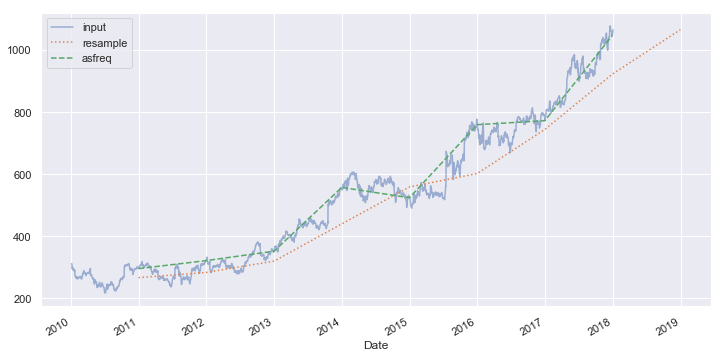

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
fig = plt.figure(figsize=(12,6))
fig.clf()
ax = fig.gca()
goog.plot(alpha=0.5, style='-', ax=ax)
goog.resample('BA').mean().plot(style=':', ax=ax)
goog.asfreq('BA').plot(style='--', ax=ax);
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

Notice the difference: at each point, resample reports the average of the previous year, while asfreq reports the value at the end of the year.

For up-sampling, resample() and asfreq() are largely equivalent, though resample has many more options available. In this case, the default for both methods is to leave the up-sampled points empty, that is, filled with NA values. Just as with the pd.fillna() function discussed previously, asfreq() accepts a method argument to specify how values are imputed. Here, we will resample the business day data at a daily frequency (i.e., including weekends):

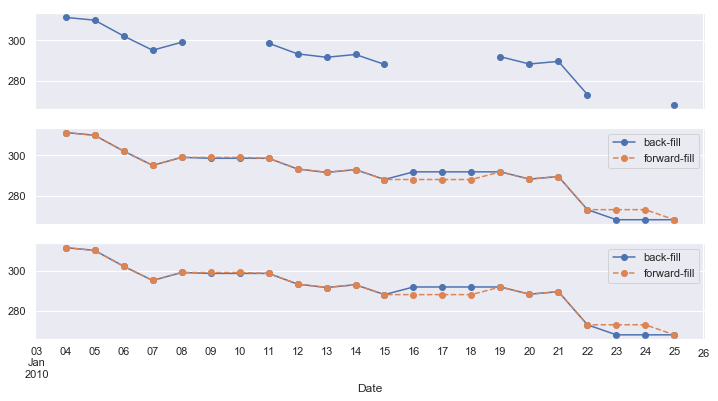

In [19]:
fig, ax = plt.subplots(3, sharex=True, figsize=(12,6))
data = goog.iloc[:15]

data.asfreq('D').plot(ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

data.resample('D').bfill().plot(ax=ax[2], style='-o')
data.resample('D').ffill().plot(ax=ax[2], style='--o')
ax[2].legend(["back-fill", "forward-fill"]);